# Colombey

## General preprocessing 

Merging data, choosing top 5 of meds and cleaning data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sales_2021 = pd.read_csv('Ventes produits par jour 2021.csv', sep=";", encoding='latin-1')
sales_2020 = pd.read_csv('Ventes produits par jour 2020.csv', sep=";", encoding='latin-1')
sales_2019 = pd.read_csv('Ventes produits par jour 2019.csv', sep=";", encoding='latin-1')
sales_2018 = pd.read_csv('Ventes produits par jour 2018.csv', sep=";", encoding='latin-1')

sales = sales_2021.merge(sales_2020, how='outer', on = ['Date facture','Désignation','Qté'])[['Date facture',
                                                                                              'Désignation','Qté']]
sales = sales.merge(sales_2019, how='outer', on = ['Date facture','Désignation','Qté'])[['Date facture',
                                                                                              'Désignation','Qté']]
sales = sales.merge(sales_2018, how='outer', on = ['Date facture','Désignation','Qté'])[['Date facture',
                                                                                              'Désignation','Qté']]

In [3]:
sales['Date'] = pd.to_datetime(sales['Date facture'], dayfirst=True)
sales = sales.drop('Date facture', axis=1)

In [4]:
sales.columns = ['Name','Quantity','Date']
sales

,Name,Quantity,Date
0,ORNIPURAL INJ 100 ML,1,2021-01-01
1,TOLFINE INJ,1,2021-01-01
2,LAXATONE TUBE 100 G,1,2021-01-01
3,SPASMIZOLE,1,2021-01-01
4,EMEPRID INJ,1,2021-01-02
...,...,...,...
42016,PROFENDER CHAT MOYEN,1,2018-12-31
42017,RC CT URINARY S/O,1,2018-12-31
42018,MILBEMAX CHIOT,1,2018-12-31
42019,DEPO MEDROL 40 MG,1,2018-12-31


In [5]:
products = sales.groupby('Name').sum('Quantity')
top5_q = products.nlargest(5,'Quantity')
top5 = top5_q.index

In [6]:
top5

Index(['SHOTAPEN', 'MILBEMAX CT', 'MILBEMAX GD CHIEN A CROQUER',
       'PREVOMAX 10MG/ML', 'BRAVECTO POUR CHIEN DE 20KG A 40KG'],
      dtype='object', name='Name')

In [7]:
sales_top5 = sales[[sales['Name'][i] in top5 for i in sales.index]]

In [8]:
sales_top5['Month'] = [sales_top5['Date'][i].replace(day=1) for i in sales_top5.index]

C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
daily = sales_top5.groupby(['Date','Name'],as_index=False).sum(['Quantity'])

In [10]:
monthly = sales_top5.groupby(['Month','Name'],as_index=False).sum('Quantity')

# Aggregating data for inventory

For each med, aggregate the sales by lead time (monday+tuesday, wednesday+thursday, friday+saturday+sunday) and compute the mean and standard deviation.
For Shotapen and Prevomax, only take 2021 data because sales increased strongly since 2018. 
For Milbemax, weird drop in sales in 2019, take 2020-2021 data.
For Bravecto, take seasonality into account.

In [14]:
from_2021 = daily[[daily['Date'][i].year == 2021 for i in daily.index]]
from_2020 = daily[[daily['Date'][i].year == 2021 or daily['Date'][i].year==2020 for i in daily.index]]

In [13]:
#depleted
def aggregate(med,daily):
    data = daily[daily['Name']==med]
    q = []
    d = []
    n = []
    dates = np.array(data['Date'])
    for date in dates:
        q_temp = 0
        day = pd.Timestamp(date).weekday()
        if day == 0 : n.append('Monday')
        if day == 2 : n.append('Wednesday')
        if day == 4 : n.append('Friday')
        nextday1 = pd.Timestamp(date) + pd.Timedelta(days=1)
        nextday2 = pd.Timestamp(date) + pd.Timedelta(days=2)
        if day == 0 or day == 2 or day == 4:
            q_temp = data[data['Date']==date]['Quantity'].iloc[0]
            if nextday1 in dates:
                q_temp = q_temp + data[data['Date']==nextday1]['Quantity'].iloc[0]
            if day == 5 and nextday2 in dates:
                q_temp = q_temp + data[data['Date']==nextday2]['Quantity'].iloc[0]
            q.append(q_temp)
            d.append(date)
        
    return pd.DataFrame({'Date':d,'Quantity':q,'Day':n})

In [15]:
def aggregate_days(med,daily):
    data = daily[daily['Name']==med]
    q = []
    d = []
    dates = np.array(data['Date'])
    for date in dates:
        q.append(data[data['Date']==date]['Quantity'].iloc[0])
        day = pd.Timestamp(date).weekday()
        if day == 0 or day == 1: 
            if day == 1 : d.append(pd.Timestamp(date)-pd.Timedelta(days=1))
            else : d.append(pd.Timestamp(date))
            #print('option1')
        elif day == 2 or day == 3: 
            if day == 3 : d.append(pd.Timestamp(date)-pd.Timedelta(days=1))
            else : d.append(pd.Timestamp(date))
            #print('option2')
        elif day == 4 or day == 5 or day == 6: 
            if day == 5 : d.append(pd.Timestamp(date)-pd.Timedelta(days=1))
            elif day == 6 : d.append(pd.Timestamp(date)-pd.Timedelta(days=2))
            else : d.append(pd.Timestamp(date))
        
    return pd.DataFrame({'Date':d,'Quantity':q})

In [16]:
milbemax = aggregate_days(top5[2],from_2020)
week_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
agg_milbemax = milbemax.groupby('Date',as_index=False).sum('Quantity')
agg_milbemax['Period'] = [week_days[pd.Timestamp(agg_milbemax['Date'][i]).weekday()] for i in agg_milbemax.index]
agg_milbemax

,Date,Quantity,Period
0,2020-01-06,1,Monday
1,2020-01-08,3,Wednesday
2,2020-01-17,2,Friday
3,2020-01-20,1,Monday
4,2020-01-24,2,Friday
...,...,...,...
250,2021-11-22,3,Monday
251,2021-11-24,3,Wednesday
252,2021-11-26,1,Friday
253,2021-11-29,3,Monday


In [17]:
shotapen = aggregate_days(top5[0],from_2021)
week_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
agg_shotapen = shotapen.groupby('Date',as_index=False).sum('Quantity')
agg_shotapen['Period'] = [week_days[pd.Timestamp(agg_shotapen['Date'][i]).weekday()] for i in agg_shotapen.index]
agg_shotapen

,Date,Quantity,Period
0,2021-01-01,1,Friday
1,2021-01-04,12,Monday
2,2021-01-06,12,Wednesday
3,2021-01-08,5,Friday
4,2021-01-11,11,Monday
...,...,...,...
138,2021-11-22,7,Monday
139,2021-11-24,11,Wednesday
140,2021-11-26,6,Friday
141,2021-11-29,5,Monday


In [18]:
# still using old aggregate method for the other meds
#agg_shotapen = aggregate(top5[0],daily[[daily['Date'][i].year == 2021 for i in daily.index]])
agg_milbemax_ct = aggregate(top5[1],daily[[daily['Date'][i].year == 2021 or daily['Date'][i].year==2020 for i in daily.index]])
agg_milbemax_chien = aggregate(top5[2],daily[[daily['Date'][i].year == 2021 or daily['Date'][i].year==2020 for i in daily.index]])
agg_prevomax = aggregate(top5[3],daily[[daily['Date'][i].year == 2021 for i in daily.index]])
agg_bravecto = aggregate(top5[4],daily)


Text(0.5, 1.0, 'PREVOMAX 10MG/ML')

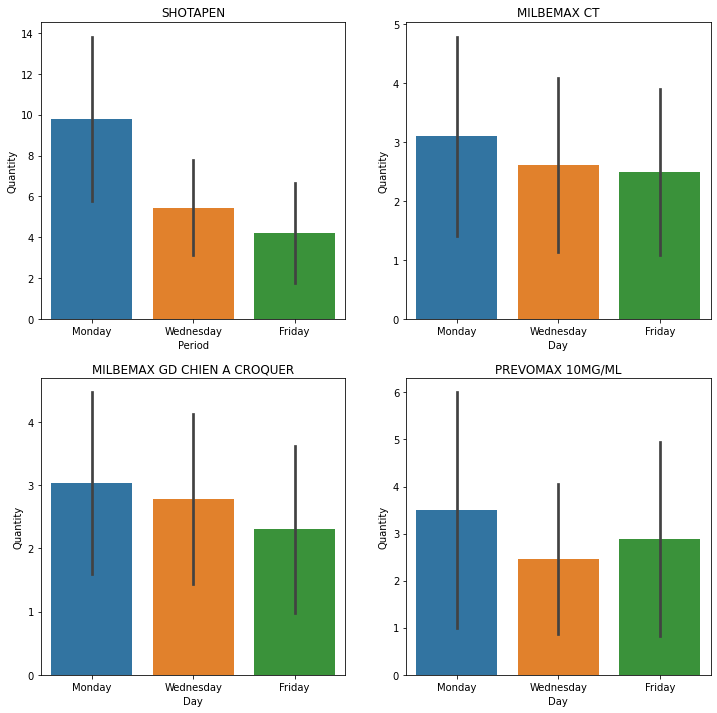

In [62]:
fig,axs = plt.subplots(2,2,figsize=(12,12))
sns.barplot(data = agg_shotapen,x='Period',y='Quantity',ci='sd',ax=axs[0,0],order = ['Monday','Wednesday','Friday'])
axs[0,0].set_title(top5[0])
sns.barplot(data = agg_milbemax_ct,x='Day',y='Quantity',ci='sd',ax=axs[0,1],order = ['Monday','Wednesday','Friday'])
axs[0,1].set_title(top5[1])
sns.barplot(data = agg_milbemax_chien,x='Day',y='Quantity',ci='sd',ax=axs[1,0],order = ['Monday','Wednesday','Friday'])
axs[1,0].set_title(top5[2])
sns.barplot(data = agg_prevomax,x='Day',y='Quantity',ci='sd',ax=axs[1,1],order = ['Monday','Wednesday','Friday'])
axs[1,1].set_title(top5[3])

#Not relevant for bravecto bc of seasonality
#sns.barplot(data = agg_bravecto,x='Day',y='Quantity',ci='sd',ax=axs[2,0],order = ['Monday','Wednesday','Friday'])
#axs[2,0].set_title(top5[4])

# Inventory models



## Milbemax Grand Chien

Trying linear programming in case one day does not have the eco friendly reduction

In [23]:
agg_milbemax[agg_milbemax['Period']=='Monday'].describe()

,Quantity
count,86.000000
mean,2.674419
std,1.466824
min,1.000000
25%,1.250000
50%,2.000000
75%,3.000000
max,6.000000


In [24]:
import cvxpy as cp

# Linear optimization
def week_order(price, sales, safety_stock, max_inventory, sigma_sales, z):
    Q = cp.Variable((3,1))
    objective = cp.Minimize(price*Q[0]+0.99*price*(Q[1]+Q[2]))
    constraints = []
    I=[]
    for i in range(0,3):
        I.append(Q[i]+Q[i-1]-sales[i-1]+safety_stock)
        constraints.append(Q[i]>=0)
        constraints.append(I[i]<=max_inventory)
        constraints.append(I[i]>=sales[i]+z*sigma_sales[i]+safety_stock)
    problem = cp.Problem(objective, constraints)
    sol = problem.solve(solver = cp.GLPK)
    return sol, Q.value
    


In [63]:
#for milbemax
price = 4.2
sales = [agg_milbemax[agg_milbemax['Period']=='Monday'].mean(),
         agg_milbemax[agg_milbemax['Period']=='Wednesday'].mean(),
         agg_milbemax[agg_milbemax['Period']=='Friday'].mean()]
sigma_sales = [agg_milbemax[agg_milbemax['Period']=='Monday'].std(),
               agg_milbemax[agg_milbemax['Period']=='Monday'].std(),
               agg_milbemax[agg_milbemax['Period']=='Monday'].std()]
z = norm.ppf(0.5)
safety_stock = 6
max_inventory = 15
milbemax_orders, Q = week_order(price, sales, safety_stock, max_inventory, sigma_sales, z)


C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


In [64]:
Q

array([[2.6744186 ],
       [2.57954545],
       [2.11111111]])

The 1% reduction is not enough to make the program order 0 on Saturdays. This happens only when the reduction is very large and the max inventory is large enough to take all the demand on 2 orders only.

## Bravecto

In [29]:
bravecto = aggregate_days(top5[4],daily)
week_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
agg_bravecto = bravecto.groupby('Date',as_index=False).sum('Quantity')
agg_bravecto['Period'] = [week_days[pd.Timestamp(agg_bravecto['Date'][i]).weekday()] for i in agg_bravecto.index]
agg_bravecto

,Date,Quantity,Period
0,2018-01-01,1,Monday
1,2018-01-03,1,Wednesday
2,2018-01-08,4,Monday
3,2018-01-10,3,Wednesday
4,2018-01-15,1,Monday
...,...,...,...
441,2021-11-08,3,Monday
442,2021-11-15,1,Monday
443,2021-11-22,1,Monday
444,2021-11-29,3,Monday


In [31]:
low_season = [1,2,11,12]
agg_bravecto['Season'] = ['Low' if agg_bravecto['Date'][i].month in low_season else 'High' for i in agg_bravecto.index]

In [32]:
agg_bravecto_high = agg_bravecto[agg_bravecto['Season']=='High']
agg_bravecto_low = agg_bravecto[agg_bravecto['Season']=='Low']

In [67]:
agg_bravecto_high.describe()

,Quantity
count,322.000000
mean,2.180124
std,1.320286
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


In [68]:
agg_bravecto_low.describe()

,Quantity
count,124.000000
mean,1.685484
std,0.858879
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


In [34]:
#for bravecto
price = 39.35
sales_high = [agg_bravecto_high[agg_bravecto_high['Period']=='Monday'].mean(),
              agg_bravecto_high[agg_bravecto_high['Period']=='Wednesday'].mean(),
              agg_bravecto_high[agg_bravecto_high['Period']=='Friday'].mean()]

sales_low = [agg_bravecto_low[agg_bravecto_low['Period']=='Monday'].mean(),
              agg_bravecto_low[agg_bravecto_low['Period']=='Wednesday'].mean(),
              agg_bravecto_low[agg_bravecto_low['Period']=='Friday'].mean()]

sigma_sales_low = [agg_bravecto_low[agg_bravecto_low['Period']=='Monday'].std(),
              agg_bravecto_low[agg_bravecto_low['Period']=='Wednesday'].std(),
              agg_bravecto_low[agg_bravecto_low['Period']=='Friday'].std()]
         
sigma_sales_high = [agg_bravecto_high[agg_bravecto_high['Period']=='Monday'].std(),
                    agg_bravecto_high[agg_bravecto_high['Period']=='Wednesday'].std(),
                    agg_bravecto_high[agg_bravecto_high['Period']=='Friday'].std()]

z = norm.ppf(0.5)
safety_stock_high = 7
safety_stock_low = 3
max_inventory = 20
bravecto_high_orders, Q_high = week_order(price, sales_high, safety_stock_high, max_inventory, sigma_sales_high, z)
bravecto_low_orders, Q_low = week_order(price, sales_low, safety_stock_low, max_inventory, sigma_sales_low, z)

C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\cl

In [37]:
Q_high

array([[2.29824561],
       [2.24528302],
       [1.98039216]])

In [39]:
Q_low

array([[1.68085106],
       [1.75555556],
       [1.59375   ]])

Same for Bravecto. 

# Milbemax Inventory Simulation

In [40]:
def simulate_milbemax(forecast, data, initial, safety_stock):
    today = pd.Timestamp(day=1,month=1,year=2021)
    delivery_day =[0,2,4]
    inventory = [initial]
    date = [today-pd.Timedelta(days=1)]
    order = [0]
    sales = [0]
    for i in range(0,335):
        if pd.to_datetime(today) in np.array(data['Date']):
            s = data[data['Date']==today]['Quantity'].iloc[0]
        else : s = 0
        if today.weekday() in delivery_day : 
            q = forecast[today.weekday()].iloc[0] + safety_stock - inventory[i]
        else : q = 0
        inventory.append(inventory[i]+q-s)
        date.append(today)
        order.append(q)
        sales.append(s)
        today = today + pd.Timedelta(days=1)
    return pd.DataFrame({'Date':date,'Inventory':inventory,'Ordered':order,'Sales':sales})

In [41]:
milbemax_2021 = from_2021[from_2021['Name']==top5[2]]

In [42]:
forecast = [np.round(agg_milbemax[agg_milbemax['Period']=='Monday'].mean(),0),0,
         np.round(agg_milbemax[agg_milbemax['Period']=='Wednesday'].mean(),0),0,
         np.round(agg_milbemax[agg_milbemax['Period']=='Friday'].mean(),0),0,0]
safety_stock = 5
simulation = simulate_milbemax(forecast, milbemax_2021, safety_stock, safety_stock)

C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
simulation

,Date,Inventory,Ordered,Sales
0,2020-12-31,5.0,0.0,0
1,2021-01-01,7.0,2.0,0
2,2021-01-02,7.0,0.0,0
3,2021-01-03,7.0,0.0,0
4,2021-01-04,7.0,1.0,1
...,...,...,...,...
331,2021-11-27,6.0,0.0,0
332,2021-11-28,6.0,0.0,0
333,2021-11-29,7.0,2.0,1
334,2021-11-30,5.0,0.0,2


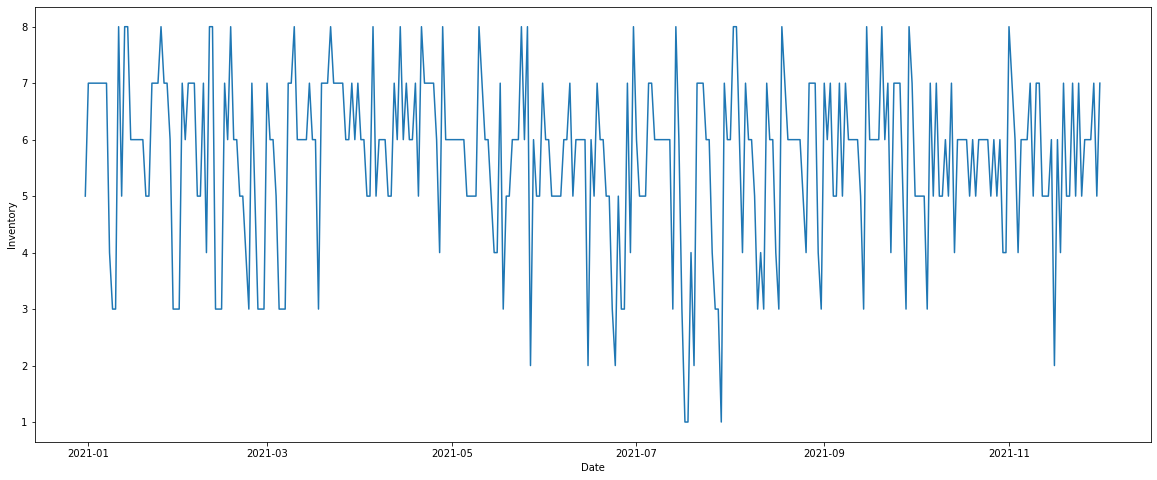

In [45]:
plt.figure(figsize=(20,8))
sns.lineplot(data=simulation, x='Date',y='Inventory')
plt.savefig('Milbemax inventory simulation.png')

# Bravecto inventory simulation

In [46]:
def simulate_bravecto(forecast_high, forecast_low, data, safety_stock_high, safety_stock_low):
    today = pd.Timestamp(day=1,month=1,year=2021)
    low_season = [1,2,9,10,11,12]
    delivery_day =[0,2,4]
    inventory = [safety_stock_low]
    date = [today-pd.Timedelta(days=1)]
    order = [0]
    sales = [0]
    for i in range(0,335):
        if pd.to_datetime(today) in np.array(data['Date']):
            s = data[data['Date']==today]['Quantity'].iloc[0]
        else : s = 0
        if today.weekday() in delivery_day : 
            if today.month in low_season :
                if today.weekday() == 0 :
                    q = forecast_low[today.weekday()].iloc[0] + safety_stock_low - inventory[i-2]
                else : 
                    q = forecast_low[today.weekday()].iloc[0] + safety_stock_low - inventory[i-1]
            else : 
                if today.weekday() == 0 :
                    q = forecast_high[today.weekday()].iloc[0] + safety_stock_high - inventory[i-2]
                else :
                    q = forecast_high[today.weekday()].iloc[0] + safety_stock_high - inventory[i-1]
                   

        else : q = 0
        inventory.append(np.round(inventory[i]+q-s,0))
        date.append(today)
        order.append(np.round(q,0))
        sales.append(s)
        today = today + pd.Timedelta(days=1)
    return pd.DataFrame({'Date':date,'Inventory':inventory,'Ordered':order,'Sales':sales})

In [52]:
bravecto_2021 = from_2021[from_2021['Name']==top5[4]]

forecast_high = [agg_bravecto_high[agg_bravecto_high['Period']=='Monday'].mean(),0,
              agg_bravecto_high[agg_bravecto_high['Period']=='Wednesday'].mean(),0,
              agg_bravecto_high[agg_bravecto_high['Period']=='Friday'].mean(),0,0]

forecast_low = [agg_bravecto_low[agg_bravecto_low['Period']=='Monday'].mean(),0,
              agg_bravecto_low[agg_bravecto_low['Period']=='Wednesday'].mean(),0,
              agg_bravecto_low[agg_bravecto_low['Period']=='Friday'].mean(),0,0]

z = norm.ppf(0.995)
safety_stock_high=np.sqrt(2)*z*agg_bravecto_high.std()[0]+4
safety_stock_low =np.sqrt(2)*z*agg_bravecto_low.std()[0]+2

simulation_b = simulate_bravecto(forecast_high,forecast_low, bravecto_2021, safety_stock_high, safety_stock_low)

C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """
C:\Users\clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\cl

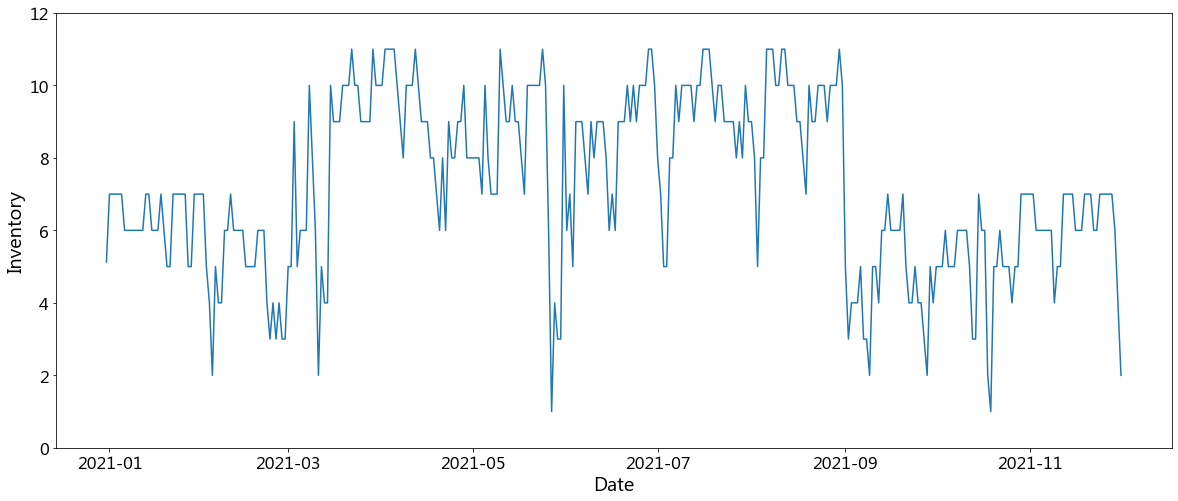

In [54]:
plt.figure(figsize=(20,8))
sns.lineplot(data=simulation_b, x='Date',y='Inventory')
plt.xlabel("Date",fontsize=20,fontfamily = 'Microsoft New Tai Lue')
plt.xticks(fontsize = 18,fontfamily = 'Microsoft New Tai Lue')
plt.yticks(fontsize = 18,fontfamily = 'Microsoft New Tai Lue')
plt.ylim(0,12)
plt.ylabel("Inventory", fontsize=20,fontfamily = 'Microsoft New Tai Lue')
plt.savefig('Bravecto inventory simulation.png')

In [58]:
total_ordered = simulation_b['Ordered'].sum()
total_ordered

235.0

In [65]:
total_cost = total_ordered * 39.35
total_cost

9247.25

In [59]:
total_sales = simulation_b['Sales'].sum()
total_sales

238

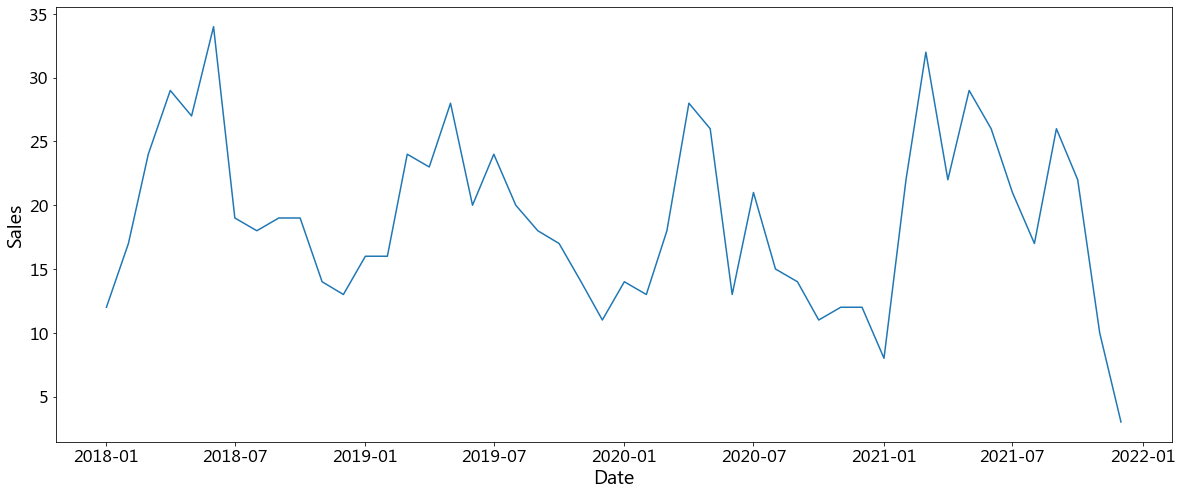

In [128]:
plt.figure(figsize=(20,8))
sns.lineplot(data=monthly[monthly['Name']==top5[4]],x='Month',y='Quantity')
plt.xlabel("Date",fontsize=20,fontfamily = 'Microsoft New Tai Lue')
plt.xticks(fontsize = 18,fontfamily = 'Microsoft New Tai Lue')
plt.yticks(fontsize = 18,fontfamily = 'Microsoft New Tai Lue')
plt.ylabel("Sales", fontsize=20,fontfamily = 'Microsoft New Tai Lue')
plt.savefig('Monthly sales bravecto.png')

# Demand analysis

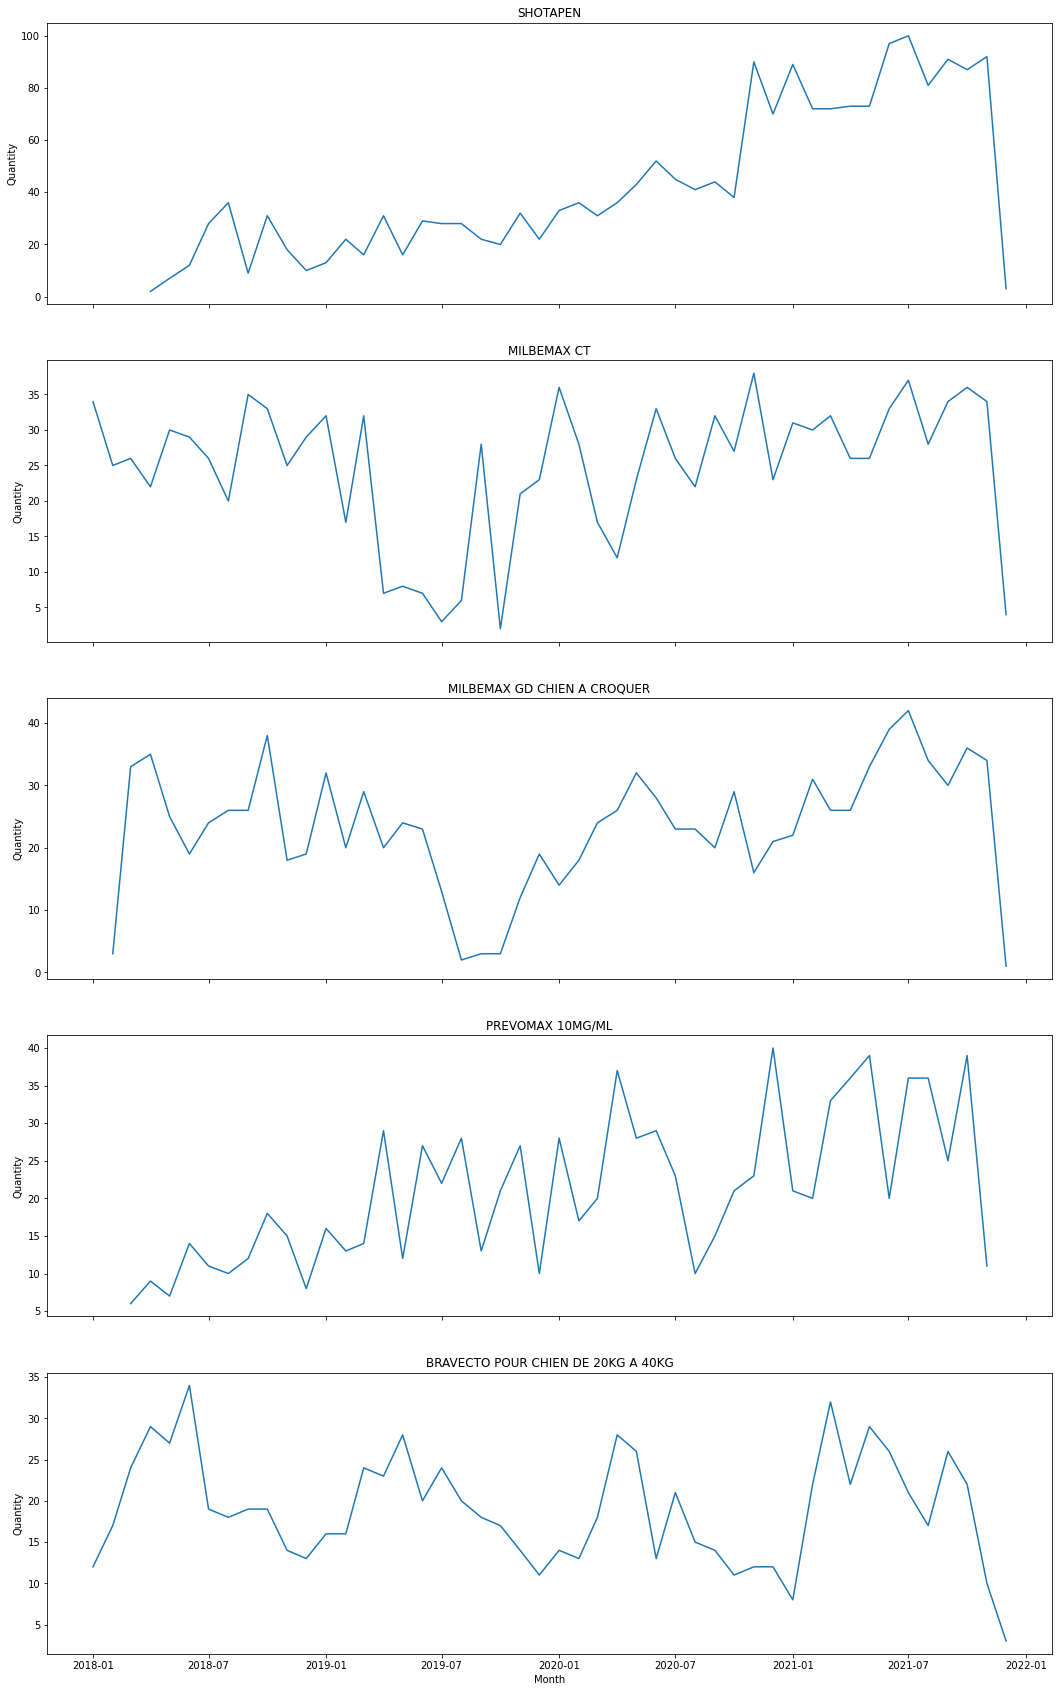

In [66]:
fig, axs = plt.subplots(5,1,figsize =(18,30),sharex=True)
for i in range(0,5):
    sns.lineplot(data=monthly[monthly['Name']==top5[i]],x='Month',y='Quantity',ax=axs[i])
    axs[i].set_title(top5[i])